In [1]:
import numpy as np
from treeple.tree import MultiViewDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from treeple.ensemble import  MultiViewRandomForestClassifier
from treeple import ObliqueRandomForestClassifier
from treeple import PatchObliqueRandomForestClassifier
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from torch.utils.data import DataLoader, Dataset, TensorDataset
from dataclasses import dataclass
import os

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".", ".."))
os.chdir(parent_dir)
os.getcwd()

'/Users/yuxinbai/Desktop/prolearn2'

### Data is independent but not identically distributed

In [2]:

@dataclass
class ProcessConfig:
    """configure the data generating process"""
    period: int = 50
    seq_len: int = 2000
    num_seeds: int = 3 

class DataGeneratingProcess:
    """data generating process"""
    def __init__(self, cfg):
        self.seq_len = cfg.seq_len
        self.num_seeds = cfg.num_seeds
        self.period = cfg.period

    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 10000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(np.arange(self.seq_len))

        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {'x': xseq,
                    'y': yseq,
                    't': tseq,
                    'task': taskseq}

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)

        # generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, self.seq_len)
        x2 = np.random.uniform(1, 2, self.seq_len)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=self.seq_len)
        Xdat = x1 * mask + x2 * (1 - mask)
        dim_noise = 5
        X_noise = np.random.normal(0, 1, size=(self.seq_len, dim_noise))

        # create labels
        T = self.period
        tind = np.array((np.arange(0, self.seq_len) % T) < (T // 2))
        tind = tind.astype(int)
        ind = np.where(tind == 1)[0]

        Ydat = Xdat > 0
        Ydat[ind] = Xdat[ind] < 0
        Ydat = Ydat.astype(int)

        Xdat = np.hstack((Xdat.reshape(-1, 1),X_noise))

        return Xdat, Ydat, tind
    
    def generate_at_time(self, t, num_samples):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor
        """
        # Generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, num_samples)
        x2 = np.random.uniform(1, 2, num_samples)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=num_samples)
        Xdat = x1 * mask + x2 * (1 - mask)
        dim_noise = 5
        X_noise = np.random.normal(0, 1, size=(num_samples, dim_noise))
        

        # create labels
        T = self.period
        if (t % T) < (T // 2):
            Ydat = Xdat < 0
        else:
            Ydat = Xdat > 0

        Xdat = np.hstack((Xdat.reshape(-1, 1),X_noise))
        tdat = t * np.ones(num_samples)

        x = torch.from_numpy(Xdat).float()
        y = torch.from_numpy(Ydat).long()
        t = torch.from_numpy(tdat).float()
        return x, y, t
    
class SyntheticDataset(Dataset):
    """Form the torch dataset"""
    def __init__(self, data, idx, run_id, test):
        # print(run_id,idx)
        self.x = torch.from_numpy(data['x']).float()
        self.y = torch.from_numpy(data['y']).long()
        self.t = torch.from_numpy(data['t']).float()

        if test:
            # Use data from time 'idx' onwards for testing
            self.x = self.x[run_id, idx:]
            self.y = self.y[run_id, idx:]
            self.t = self.t[run_id, idx:]
        else:
            # Use data up to time 'idx' onwards for training
            self.x = self.x[run_id, :idx]
            self.y = self.y[run_id, :idx]
            self.t = self.t[run_id, :idx]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t

In [3]:
def get_dataloaders(dp, t, seed):
    """obtain the dataloaders"""
    train_dataset = SyntheticDataset(dp.data, t, seed, test=False)
    test_dataset = SyntheticDataset(dp.data, t, seed, test=True)
    # ttest_dataset = TensorDataset(*dp.generate_at_time(t, 500))
    trainloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    # ttestloader = DataLoader(
    #     ttest_dataset, 
    #     batch_size=100,
    #     shuffle=False
    # )
    return train_dataset,test_dataset,trainloader, testloader

In [4]:
import torch.nn as nn

class TimeEmbedding(nn.Module):
    """form the time-embedding"""
    def __init__(self, tdim=10):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2).unsqueeze(0)

    def forward(self, t):
        # print(t.device)
        sin_emb = torch.sin(self.freqs.to(t.device) * t)
        cos_emb = torch.cos(self.freqs.to(t.device) * t)
        return torch.cat([sin_emb, cos_emb], dim=-1)
    
class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, in_dim=1, out_dim=2, hidden_dim=32, tdim=50, prospective=False):
        super(MLP, self).__init__()
        self.prospective = prospective
        if prospective:
            self.time_embed = TimeEmbedding(tdim=tdim)
            self.fc1 = nn.Linear(in_dim + tdim, hidden_dim)
        else:
            self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, t):
        if self.prospective:
            t = self.time_embed(t.unsqueeze(-1))
            x = torch.cat([x, t], dim=-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [5]:
class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, test_loader, criterion, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            x, y, t = batch
            outputs = self.model(x, t)

            loss = self.criterion(outputs.squeeze(), y)

            self.optimizer.zero_grad()  
            loss.backward()            
            self.optimizer.step() 

            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def evaluate(self):
        self.model.eval()
        errs = []
        with torch.no_grad():
            for batch in self.test_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                errs.append(err.cpu().numpy())
        ploss = np.concatenate(errs).mean()

        return ploss

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch()
            if self.verbose:
                print(f'Epoch [{epoch + 1}/{num_epochs}], '
                    f'Train Loss: {train_loss:.4f}, ')
        print(f"training loss at last epoch: {train_loss:.3f}")

Text(0, 0.5, 'X')

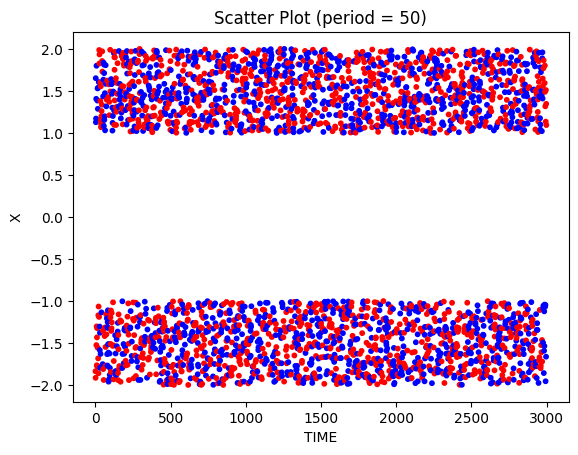

In [6]:
# Data visualization
cfg = ProcessConfig(
    period=50,
    seq_len=3000,
    num_seeds=1,
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()
data  = dp.data

colors = ['b' if label == 0 else 'r' for label in data['y'].flatten().tolist()]
plt.scatter(data['t'],data['x'][:,:,0],c = colors,s = 10)
plt.title('Scatter Plot (period = 50)')
plt.xlabel('TIME')
plt.ylabel('X')


In [ ]:
cfg = ProcessConfig(
period=50,
seq_len=3000,
num_seeds=5)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

t_list = np.arange(50, 1500, 100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tdim = 50
RISK_PGBTs = []
RISK_GBTs = []
RISK_PMLPs = []
for seed in range(5):
    
    RISK_PGBT = []
    RISK_GBT = []

    RISK_PMLP = []
    RISK_MLP = []
    for t in t_list:
        print(t)
        train_dataset,test_dataset,trainloader, testloader = get_dataloaders(dp, t, seed)
        
        T_train = train_dataset.t
        x_train = train_dataset.x.numpy()
        Y_train = train_dataset.y.flatten().tolist()
        print(T_train.shape)
        
        
        T_test = test_dataset.t
        x_test = test_dataset.x.numpy()
        Y_test = test_dataset.y.flatten().tolist()
        
        # Add time encoding
        time_embed = TimeEmbedding(tdim=tdim)
        timeembed_train= time_embed(T_train.unsqueeze(-1)).numpy()
        timeembed_test= time_embed(T_test.unsqueeze(-1)).numpy()
        
        X_train= np.hstack((x_train,timeembed_train))
        X_test= np.hstack((x_test,timeembed_test))
        
        # Train on Gradient Boosting Trees
        PGBT = GradientBoostingClassifier(n_estimators=1000)
        PGBT.fit(X_train,Y_train)
        
        # Test on Gradient Boosting Trees
        Y_pred_pgbt = PGBT.predict(X_test)
        risk_pgbt = (Y_test != Y_pred_pgbt).astype(int).mean()
        
        # Train on Time-agnostic Gradient Boosting Trees
        GBT = GradientBoostingClassifier(n_estimators=1000)
        GBT.fit(x_train,Y_train)
        
        # Test on Time-agnostic Gradient Boosting Trees
        Y_pred_gbt = GBT.predict(x_test)
        risk_gbt = (Y_test != Y_pred_gbt).astype(int).mean()
        
        # Train and evaluate on MLP
        prospective = True
        model = MLP(in_dim = 6,prospective=prospective,tdim = tdim)
        model.to(device)

        optimizer = torch.optim.SGD(
            model.parameters(), lr=0.1,
            momentum=0.9, nesterov=True,
            weight_decay=0.00001)
        criterion = nn.CrossEntropyLoss()

        trainer = Trainer(model, trainloader, testloader, criterion, optimizer, device)
        trainer.train(num_epochs=100)
        ploss = trainer.evaluate()
                
        # Save prospectove risk
        RISK_PGBT.append(risk_pgbt)
        RISK_GBT.append(risk_gbt)
        RISK_PMLP.append(ploss)
    RISK_PGBTs.append(RISK_PGBT)
    RISK_GBTs.append(RISK_GBT)
    RISK_PMLPs.append(RISK_PMLP)
RISK_PGBTs_DF = np.concatenate(RISK_PGBTs).reshape(5,-1)
RISK_GBTs_DF = np.concatenate(RISK_GBTs).reshape(5,-1)
RISK_PMLPs_DF = np.concatenate(RISK_PMLPs).reshape(5,-1)
np.savetxt("./results/prospective_forests/RISK_PGBTs_Scenario2.csv", RISK_PGBTs_DF, delimiter=",", fmt="%.6f")
np.savetxt("./results/prospective_forests/RISK_GBTs_Scenario2.csv", RISK_GBTs_DF, delimiter=",", fmt="%.6f")
np.savetxt("./results/prospective_forests/RISK_PMLPs_Scenario2.csv", RISK_PMLPs_DF, delimiter=",", fmt="%.6f")

### Data is neither independent nor identically distributed

In [15]:
class Scenario3:
    def __init__(self, cfg):
        self.seq_len = cfg.seq_len
        self.num_seeds = cfg.num_seeds
        self.period = cfg.period
        self.cfg = cfg
        self.variant = cfg.variant

    def generate_data(self):
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for sd in range(self.num_seeds):
            # Markov chain with 2 states, reset ever K steps
            if self.variant == 'markov2':
                dat = self.gen_sequence_markov2(sd, stationary=False)
            # Markov chain that equilibriates to the stationary distribution
            if self.variant == 'markov2_s':
                dat = self.gen_sequence_markov2(sd, stationary=True)
            # Markov chain with 4 states (described in the paper)
            elif self.variant == 'markov4':
                dat = self.gen_sequence_markov4(sd)
            else:
                raise ValueError('Invalid variant')
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(np.arange(self.seq_len))

        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {
            'x': xseq,
            'y': yseq,
            't': tseq,
            'task': taskseq,
            'cfg': self.cfg}
class SyntheticScenario3(Scenario3):
    """
    Generate data from a markov process
    """
    def gen_sequence_markov4(self, seed):
        np.random.seed(seed)

        # create task indices
        T = self.period
        cur_t = 0
        tind = []
        for i in range(self.seq_len):
            tind.append(cur_t)

            # Every T steps, switch task
            if (i + 1) % T == 0:
                cur_t = 0
            elif (i + 1) % (T // 2) == 0:
                cur_t = 1

            if cur_t <= 1:
                # Change task with probability 0.2
                if np.random.rand() < 0.2:
                    cur_t = 2 - cur_t
            else:
                # Change task with probability 0.2
                if np.random.rand() < 0.2:
                    cur_t = 4 - cur_t
        tind = np.array(tind)

        # generate a samples from U[1, 2]
        x1 = np.random.uniform(1, 2, self.seq_len)
        x2 = np.random.uniform(1, 2, self.seq_len)
        Xdat = np.stack([x1, x2]).T

        # Generate labels 
        Ydat = np.random.choice([0, 1], size=self.seq_len)

        # Generate data points
        tind_m = (tind + Ydat) % 4

        xmask1 = 1 - (tind_m < 2) * 2
        xmask2 = 1 - (tind_m >= 1) * (tind_m <= 2) * 2

        xmask = np.stack([xmask1, xmask2]).T
        Xdat = Xdat * xmask
        
        dim_noise = 2
        X_noise = np.random.normal(0, 1, size=(self.seq_len, dim_noise))
        Xdat = np.hstack((Xdat.reshape(-1, 2),X_noise))
        # print(Xdat.shape,tind.shape)
        

        return Xdat, Ydat, tind

    def gen_sequence_markov2(self, seed, stationary=False):
        np.random.seed(seed)
    
        # Create task indices
        T = self.period
        cur_t = 0
        tind = []
        for i in range(self.seq_len):
            tind.append(cur_t)
    
            # Every T steps, switch task
            if (not stationary) and (i + 1) % T == 0:
                cur_t = 0
            else:
                # Change task with probability 0.9
                if np.random.rand() < 0.9:
                    cur_t = 1 - cur_t
    
        tind = np.array(tind)
    
        # Generate samples from U[-2, -1] and U[1, 2]
        x1 = np.random.uniform(-2, -1, self.seq_len)
        x2 = np.random.uniform(1, 2, self.seq_len)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=self.seq_len)
        Xdat = x1 * mask + x2 * (1 - mask)
    
        # Create labels
        Ydat = np.zeros(self.seq_len, dtype=int)
        Ydat[tind == 0] = (Xdat[tind == 0] > 0).astype(int)
        Ydat[tind == 1] = (Xdat[tind == 1] < 0).astype(int)
    
        Xdat = Xdat.reshape(-1, 1)

        return Xdat, Ydat, tind

    def store_data(self):
        os.makedirs('data/synthetic', exist_ok=True)
        with open('data/synthetic/scenario3_%s.pkl' % self.variant, 'wb') as fp:
            pickle.dump(self.data, fp)

In [16]:
class Object(object):
    pass 
cfg = Object()
cfg.variant= 'markov4'
cfg.seq_len = 5000
cfg.num_seeds = 5
cfg.period = 20
datagen = SyntheticScenario3(cfg)

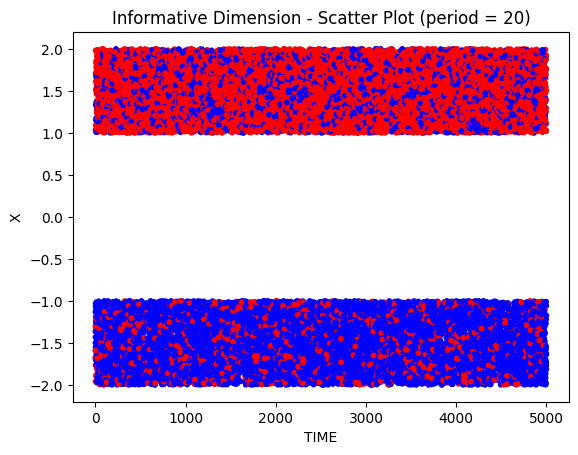

Text(0, 0.5, 'X')

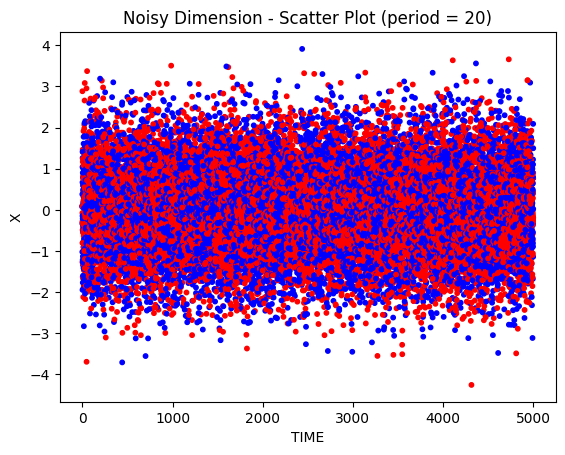

In [17]:
dp = SyntheticScenario3(cfg)
dp.generate_data()
data  = dp.data

colors = ['b' if label == 0 else 'r' for label in data['y'].flatten().tolist()]
plt.scatter(data['t'],data['x'][:,:,0],c = colors,s = 10)
plt.title('Informative Dimension - Scatter Plot (period = 20)')
plt.xlabel('TIME')
plt.ylabel('X')
plt.show()
colors = ['b' if label == 0 else 'r' for label in data['y'].flatten().tolist()]
plt.scatter(data['t'],data['x'][:,:,3],c = colors,s = 10)
plt.title('Noisy Dimension - Scatter Plot (period = 20)')
plt.xlabel('TIME')
plt.ylabel('X')


In [ ]:
t_list = np.arange(50, 1500, 100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tdim = 50
RISK_PGBTs = []
RISK_GBTs = []
RISK_PMLPs = []
for seed in range(5):
    
    RISK_PGBT = []
    RISK_GBT = []

    RISK_PMLP = []
    RISK_MLP = []
    for t in t_list:
        print(t)
        train_dataset,test_dataset,trainloader, testloader = get_dataloaders(dp, t, seed)
        
        T_train = train_dataset.t
        x_train = train_dataset.x.numpy()
        Y_train = train_dataset.y.flatten().tolist()
        print(T_train.shape)
        
        
        T_test = test_dataset.t
        x_test = test_dataset.x.numpy()
        Y_test = test_dataset.y.flatten().tolist()
        
        # Add time encoding
        time_embed = TimeEmbedding(tdim=tdim)
        timeembed_train= time_embed(T_train.unsqueeze(-1)).numpy()
        timeembed_test= time_embed(T_test.unsqueeze(-1)).numpy()
        
        X_train= np.hstack((x_train,timeembed_train))
        X_test= np.hstack((x_test,timeembed_test))
        
        # Train on Gradient Boosting Trees
        PGBT = GradientBoostingClassifier(n_estimators=1000)
        PGBT.fit(X_train,Y_train)
        
        # Test on Gradient Boosting Trees
        Y_pred_pgbt = PGBT.predict(X_test)
        risk_pgbt = (Y_test != Y_pred_pgbt).astype(int).mean()
        
        # Train on Time-agnostic Gradient Boosting Trees
        GBT = GradientBoostingClassifier(n_estimators=1000)
        GBT.fit(x_train,Y_train)
        
        # Test on Time-agnostic Gradient Boosting Trees
        Y_pred_gbt = GBT.predict(x_test)
        risk_gbt = (Y_test != Y_pred_gbt).astype(int).mean()
        
        # Train and evaluate on MLP
        prospective = True
        model = MLP(in_dim = 4,prospective=prospective,tdim = tdim)
        model.to(device)

        optimizer = torch.optim.SGD(
            model.parameters(), lr=0.1,
            momentum=0.9, nesterov=True,
            weight_decay=0.00001)
        criterion = nn.CrossEntropyLoss()

        trainer = Trainer(model, trainloader, testloader, criterion, optimizer, device)
        trainer.train(num_epochs=100)
        ploss = trainer.evaluate()
                
        # Save prospectove risk
        RISK_PGBT.append(risk_pgbt)
        RISK_GBT.append(risk_gbt)
        RISK_PMLP.append(ploss)
    RISK_PGBTs.append(RISK_PGBT)
    RISK_GBTs.append(RISK_GBT)
    RISK_PMLPs.append(RISK_PMLP)
RISK_PGBTs_DF = np.concatenate(RISK_PGBTs).reshape(5,-1)
RISK_GBTs_DF = np.concatenate(RISK_GBTs).reshape(5,-1)
RISK_PMLPs_DF = np.concatenate(RISK_PMLPs).reshape(5,-1)
np.savetxt("./results/prospective_forests/RISK_PGBTs_Scenario3.csv", RISK_PGBTs_DF, delimiter=",", fmt="%.6f")
np.savetxt("./results/prospective_forests/RISK_GBTs_Scenario3.csv", RISK_GBTs_DF, delimiter=",", fmt="%.6f")
np.savetxt("./results/prospective_forests/RISK_PMLPs_Scenario3.csv", RISK_PMLPs_DF, delimiter=",", fmt="%.6f")

### Read Results

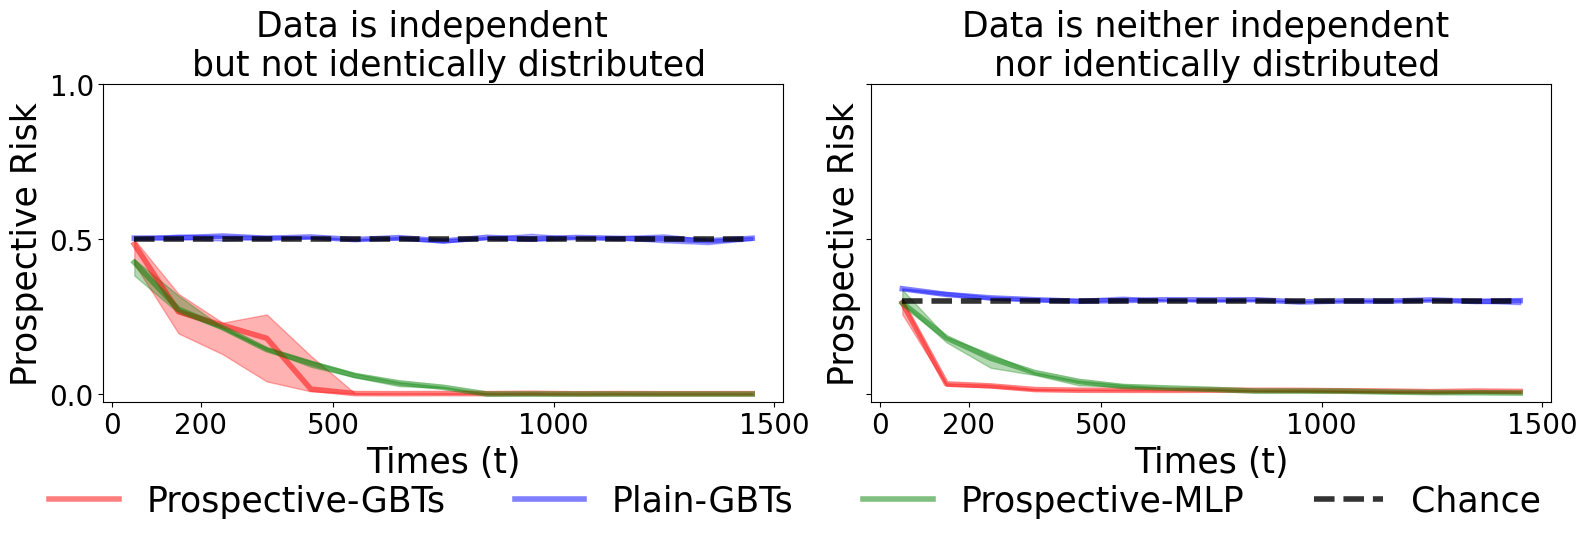

In [3]:
# Load data for scenario 2
RISK_PGBTs_DF = np.loadtxt("./results/prospective_forests/RISK_PGBTs_Scenario2.csv", delimiter=",")
RISK_GBTs_DF = np.loadtxt("./results/prospective_forests/RISK_GBTs_Scenario2.csv", delimiter=",")
RISK_PMLPs_DF = np.loadtxt("./results/prospective_forests/RISK_PMLPs_Scenario2.csv", delimiter=",")

# Load data for scenario 3
RISK_PGBTs_DF_s3 = np.loadtxt("./results/prospective_forests/RISK_PGBTs_Scenario3.csv", delimiter=",")
RISK_GBTs_DF_s3 = np.loadtxt("./results/prospective_forests/RISK_GBTs_Scenario3.csv", delimiter=",")
RISK_PMLPs_DF_s3 = np.loadtxt("./results/prospective_forests/RISK_PMLPs_Scenario3.csv", delimiter=",")

# Define time array
TIME = np.arange(50, 1500, 100)

# Create the figure and subplots
fontsize=fontsize = 25
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
def plot_risk(ax, risk_pg, risk_gbt, risk_mlp, title, show_legend):
    # Plot TimeGBT with IQR
    ax.plot(TIME, np.median(risk_pg, axis=0), alpha=0.5, label='Prospective-GBTs', color='red',linewidth = 4)
    ax.fill_between(TIME, np.quantile(risk_pg, 0.25, axis=0), np.quantile(risk_pg, 0.75, axis=0), alpha=0.3, color='red')

    # Plot PlainGBT with IQR
    ax.plot(TIME, np.median(risk_gbt, axis=0), alpha=0.5, label='Plain-GBTs', color='blue',linewidth = 4)
    ax.fill_between(TIME, np.quantile(risk_gbt, 0.25, axis=0), np.quantile(risk_gbt, 0.75, axis=0), alpha=0.3, color='blue')

    # Plot TimeMLP with IQR
    ax.plot(TIME, np.median(risk_mlp, axis=0), alpha=0.5, label='Prospective-MLP', color='green',linewidth = 4)
    ax.fill_between(TIME, np.quantile(risk_mlp, 0.25, axis=0), np.quantile(risk_mlp, 0.75, axis=0), alpha=0.3, color='green')

    # Plot the "Chance" line
    if ax == axs[0]:
        ax.plot(TIME, 0.5 * np.ones(len(TIME)), label='Chance', color='k', linestyle='--', alpha=0.8,linewidth = 4)
    if ax == axs[1]:
        ax.plot(TIME, 0.3 * np.ones(len(TIME)), label='Chance', color='k', linestyle='--', alpha=0.8,linewidth = 4)

    # Set titles and labels
    ax.set_title(title,fontsize=fontsize)
    ax.set_ylabel('Prospective Risk',fontsize=fontsize)
    ax.set_xlabel('Times (t)',fontsize=fontsize)
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticks([0, 200, 500, 1000, 1500])
    ax.tick_params(axis='both', labelsize=fontsize-5)
    
    # Show legend only in the first subplot
    if show_legend:
        ax.legend(loc='upper right')

# Plot Scenario 2
plot_risk(axs[0], RISK_PGBTs_DF, RISK_GBTs_DF, RISK_PMLPs_DF, "Data is independent  \n but not identically distributed", show_legend=False)

# Plot Scenario 3
plot_risk(axs[1], RISK_PGBTs_DF_s3, RISK_GBTs_DF_s3, RISK_PMLPs_DF_s3, "Data is neither independent \n nor identically distributed", show_legend=False)

# Add a single legend outside the plot box
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.11),fontsize=fontsize)

# Adjust layout to accommodate the external legend
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.show()
